In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.integrate as integrate
from tqdm import tqdm

In [2]:
class BayesianCalculator:
    
    # Channels
    
    def __init__(self, channels):
        
        self.n = channels[:,0]
        self.b = channels[:,1]
        self.s = channels[:,2]
        self.NChannels = len(self.n)
        
    def PrintChannel(self):
        for i in range(self.NChannels):
            print(i,':',self.n[i],self.b[i],self.s[i])
        
    # Parameter of interes POI (mu)    
        
    def SetPOI(self,min_,max_,Npoints_):
        self.mu = np.linspace(min_,max_,Npoints_)
        
    def GetPOI(self):
        return self.mu
        
    # Bayesian methods
    
    def Prior(self,mu):
        
        if np.isscalar(mu):
            if mu > 0:
                return 1.0
            else:
                return 0.
        else:
            if mu.any() > 0.:
                return 1.0
            else:
                return 0.
       
    # Poissonian Likelihood
    def Likelihood(self,n,b,s,mu):
        lambda_ = mu*s + b
        return np.exp(-lambda_)*lambda_**n / np.math.factorial(n)
    
    def JointLikelihood(self,mu):
        
        like = 1.0
        
        for c in range(self.NChannels):
            
            # Likelihood
            like *= self.Likelihood(self.n[c],self.b[c],self.s[c],mu)
            # Prior
            like *= self.Prior(mu)
        
        return like
    
    def GetJointLikelihood(self):
        return self.JointLikelihood(self.mu)
    
    def GetNormalization(self):
        self.Normalization = integrate.quad(self.JointLikelihood,self.mu[0],self.mu[-1])[0]
        return self.Normalization

    def GetPosterior(self):
        return self.JointLikelihood(self.mu)/self.GetNormalization()
    
    
    # For closure test, posterior##############
    def GetPosteriorFunction(self,mu):
        return self.JointLikelihood(mu)/self.GetNormalization()
    
    def PosteriorIntegral(self):
        print(integrate.quad(self.GetPosteriorFunction,self.mu[0],self.mu[-1])[0])
    ################
    
    # Pvalue zone
    def GetPValue(self):
        
        self.pvalue = np.zeros(len(self.mu)-1)
        
        for i in range(len(self.pvalue)):
            self.pvalue[i] = 1. - integrate.quad(self.JointLikelihood,0.,self.mu[i])[0]/self.GetNormalization()
            
        return self.pvalue
        
    # UpperLimit
    
    def GetUpperLimit(self, p=0.05):
        
        self.pvalue = self.GetPValue()
        
        i = np.where( self.pvalue <= p )
        
        if len(i[0]) == 0:
            print('--- No calculable ---')
            return 0.
        else:
            i = i[0][0]
            
        x0 = self.mu[i-1]
        x1 = self.mu[i]
        y0 = self.pvalue[i-1]
        y1 = self.pvalue[i]
    
        # Calulamos pendiente
        m = (y1-y0)/(x1-x0)
    
        if m == 0.:
            print('---No calculable---')
            return 0.
        
        self.mup = (p - y0)/m + x0
    
        return self.mup        

In [3]:
#channels = np.array([[2,3.5,1.],[5,3.,2.]])
channels = np.array([[2,3.5,1.]])

In [4]:
b1 = BayesianCalculator(channels)
b1.SetPOI(0.,15.,100)
upper = b1.GetUpperLimit()

#b1.PrintChannel()
#b1.PosteriorIntegral()

In [5]:
class Plotter:
    
    def __init__(self,):
        
        self.fig = plt.figure(figsize=(6,6),dpi=100)
        self.ax = self.fig.add_subplot(1,1,1)
        self.folder = '../Figures/'
         
    def PlotJoint(self,x,y,figname='',label_='\mathcal{L}(\mu) \pi(\mu)'):
        self.ax.plot(x,y,'k',lw=2,label=r'$'+label_+'$')
        self.SetStyle(x,y,xlabel_='\mu',ylabel_='')
        self.SaveFig(figname)
    
    def PlotPosterior(self,x,y,figname='',label_='p(\mu)=\mathcal{L}(\mu) \pi(\mu)/C'):
        self.ax.plot(x,y,'k',lw=2,label=r'$'+label_+'$')
        self.SetStyle(x,y,xlabel_='\mu',ylabel_='')
        self.SaveFig(figname)
        
    def PlotPvalue(self,x,y,figname='',label_=r'Observed limit'):
        self.ax.plot(x,y,marker='o',color='k',lw=2,label=label_)
        self.ax.axhline(y=0.05,ls='--',color='r',lw=2, label=r'$95\% \ CL$')
        self.SetStyle(x,y,xlabel_='\mu',ylabel_='p-value')
        self.SaveFig(figname)
    
    def PlotUpperLimit(self,x,y,upperlimit,figname='',label_=r'p(\mu)=\mathcal{L}(\mu) \pi(\mu)/C'):
        self.ax.plot(x,y,'k',lw=2,label=r'$'+label_+'$')
        self.ax.axvline( x = upperlimit, color='r', linestyle='--', label=r'$\mu^{up}$: %.3f'%(upperlimit) )
        
        upper_ = np.linspace(upperlimit,np.max(x),100)
        self.ax.fill_between(upper_,0,b1.GetPosteriorFunction(upper_),color='b')
        self.SetStyle(x,y,xlabel_='\mu',ylabel_='')
        self.SaveFig(figname)
    
   
    def SetStyle(self,x,y,xlabel_,ylabel_,scale_=1.0, fontsize_=16):
        
        ticks_x = ticker.FuncFormatter(lambda x,pos:'{:.2f}'.format(x/scale_))
        self.ax.xaxis.set_major_formatter(ticks_x)

        ticks_y = ticker.FuncFormatter(lambda y,pos:'{:.2f}'.format(y/scale_))
        self.ax.yaxis.set_major_formatter(ticks_y)
        
        self.ax.tick_params(axis='both', which='major', labelsize=12)
        
        self.ax.set_xlim(x[0],x[-1])
        self.ax.set_ylim(np.min(y),np.max(y))
        
        self.ax.set_xlabel(r'$'+xlabel_+'$',fontsize=fontsize_)
        self.ax.xaxis.set_label_coords(0.96, -0.1)
        
        if ylabel_ == '':
            self.ax.set_ylabel('',fontsize=fontsize_)
        else:    
            self.ax.set_ylabel(r'$'+ylabel_+'$',fontsize=fontsize_)
        
        self.ax.yaxis.set_label_coords(-0.1, 0.96)

        self.ax.legend(loc=1,prop={'size': 14}) 

    def SaveFig(self,figname=''):
        self.folder += figname
        plt.savefig(self.folder)
        plt.close()

In [6]:
plot1 = Plotter()
plot1.PlotJoint(b1.GetPOI(),b1.GetJointLikelihood(),'Bayesian_JointLikelihood.pdf')
plot2 = Plotter()
plot2.PlotPosterior(b1.GetPOI(),b1.GetPosterior(),'Bayesian_Posterior.pdf')
plot3 = Plotter()
plot3.PlotPvalue(b1.GetPOI()[:-1],b1.GetPValue(),'Bayesian_PvalueScan.pdf')
plot4 = Plotter()
plot4.PlotUpperLimit(b1.GetPOI(),b1.GetPosterior(),upper,'Bayesian_PosteriorDist_UpperL.pdf')

In [13]:
def SetStyle(ax,x,y,xlabel_,ylabel_,scale_=1., fontsize_=16):
    
    ticks_x = ticker.FuncFormatter(lambda x,pos:'{:.2f}'.format(x/scale_))
    ax.xaxis.set_major_formatter(ticks_x)

    ticks_y = ticker.FuncFormatter(lambda y,pos:'{:.1f}'.format(y/scale_))
    ax.yaxis.set_major_formatter(ticks_y)

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlim(x[0],x[-1])
    #ax.set_ylim(np.min(y),np.max(y))
    ax.set_ylim(-2,15)
    
    ax.set_xlabel(r'$'+xlabel_+'$',fontsize=fontsize_)
    ax.xaxis.set_label_coords(0.96, -0.1)

    if ylabel_ == '':
        ax.set_ylabel('',fontsize=fontsize_)
    else:    
        ax.set_ylabel(r'$'+ylabel_+'$',fontsize=fontsize_)
            
    ax.yaxis.set_label_coords(-0.1, 0.96)

    ax.legend(loc=1,prop={'size': 10})  

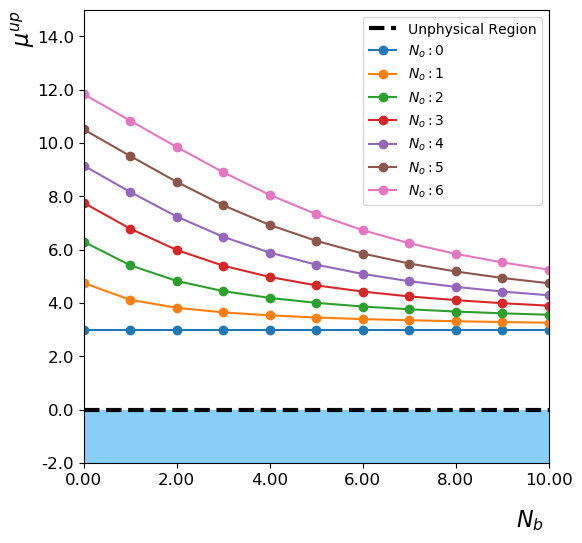

In [14]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(1,1,1)

b = np.linspace(0,10,11)
upperlimits = np.zeros(len(b)) 

ax.axhline( y = 0, color='k', lw=3, linestyle='--', label='Unphysical Region' )
ax.fill_between(b,-2,0,color='lightskyblue')

for i in range(7):
    for j in range(len(b)):
        channels = np.array([[i,b[j],1.]])
        b1 = BayesianCalculator(channels)
        b1.SetPOI(0.,20.,100)
        upperlimits[j] = b1.GetUpperLimit()

        
    ax.plot(b,upperlimits,marker='o',label=r'$N_{o}: %.0f$'%(i))    

SetStyle(ax,b,b,xlabel_='N_{b}',ylabel_='\mu^{up}')

plt.legend(loc=1)

folder = '../Figures/'
folder += 'Bayesian_Background_Scan.pdf'

plt.savefig(folder)